# Exercise 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint, chi2

In [2]:
def chi2_test(samples, ps):

    idx, counts = np.unique(samples, return_counts=True)

    n = np.zeros_like(ps)
    n[idx.astype(int)] = counts

    n_exp = ps * np.sum(n)

    T = np.sum((n - n_exp)** 2 / n_exp)

    # test stat follows chi2(k - 1), week 1 slide 10
    return 1 - chi2.cdf(T, len(ps) - 1)

Acceptance rate: 0.8883
P-value: 0.0039045347816476506


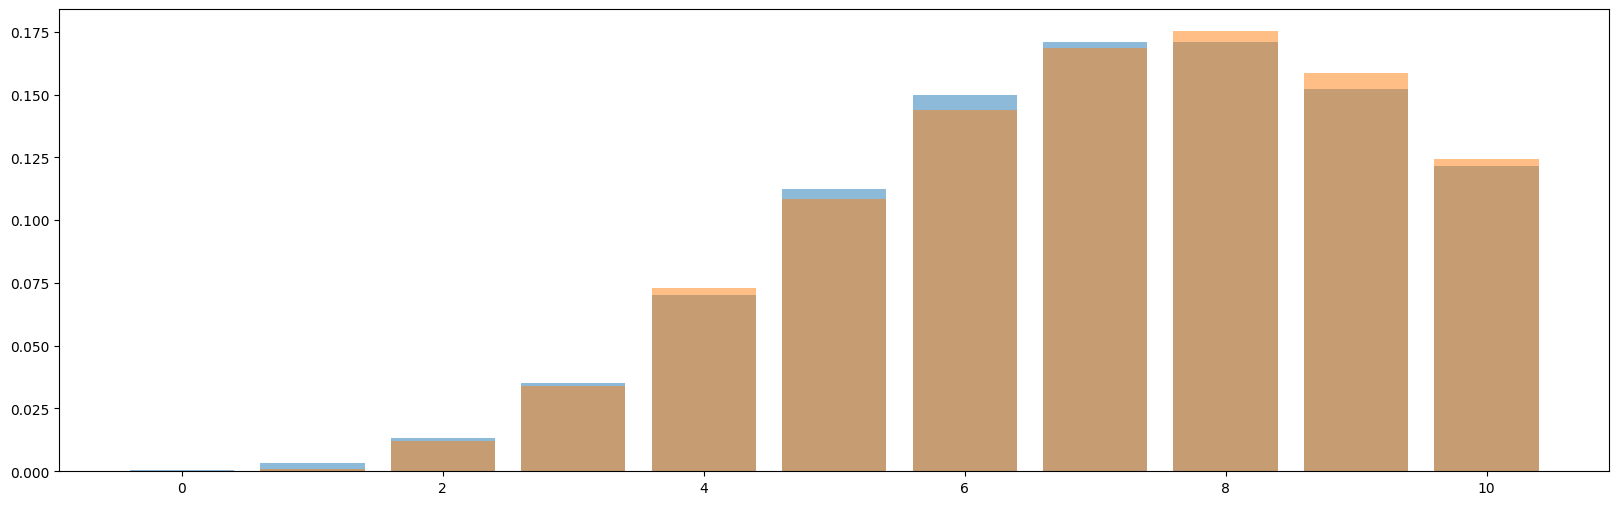

In [12]:
m = 10

class RW:
    def rvs(self):
        if uniform.rvs() < 0.5:
            return -1
        return 1
    
    def pdf(self, x, y):
        if abs(x - y) == 1:
            return 0.5
        return 0


proposal_dist = RW() 

def factorial(n):
    if n in [0, 1]:
        return 1
    return n * factorial(n - 1)

def target_dist_pdf(i):
    A = 8
    return A**i / factorial(i)


def metropolis_hastings(target_dist_pdf, proposal_dist_pdf, proposal_dist_rvs, initial_value, N):
    samples = np.empty(N + 1)
    samples[0] = initial_value
    accepted = np.empty(N + 1)
    accepted[0] = True

    for n in range(1, N + 1):
        proposed_val = samples[n - 1] + proposal_dist.rvs()
        proposed_val = max(0, min(proposed_val, m))

        p_accept = min(1, target_dist_pdf(proposed_val) / target_dist_pdf(samples[n - 1]))

        if uniform.rvs() < p_accept:
            samples[n] = proposed_val
            accepted[n] = True
        else:
            samples[n] = samples[n - 1]
            accepted[n] = False

    return samples[1:], accepted[1:]

samples, accepted = metropolis_hastings(target_dist_pdf, proposal_dist.pdf, proposal_dist.rvs, initial_value=5, N=10_000)

print("Acceptance rate:", np.mean(accepted))

idx, c = np.unique(samples, return_counts=True)

counts = np.zeros(m + 1)
counts[idx.astype(int)] = c
counts /= np.sum(counts)

xs = np.arange(m + 1)
pi = np.array([target_dist_pdf(i) for i in xs])
pi /= np.sum(pi)

print("P-value:", chi2_test(samples[N // 2:], pi))


fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

ax1.bar(xs, pi, alpha=0.5)
ax1.bar(xs, counts, alpha=0.5);

(array([62.,  6.,  4.,  2.,  1.,  9.,  7.,  5.,  0.,  4.]),
 array([0.        , 0.09309203, 0.18618407, 0.2792761 , 0.37236813,
        0.46546016, 0.5585522 , 0.65164423, 0.74473626, 0.8378283 ,
        0.93092033]),
 <BarContainer object of 10 artists>)

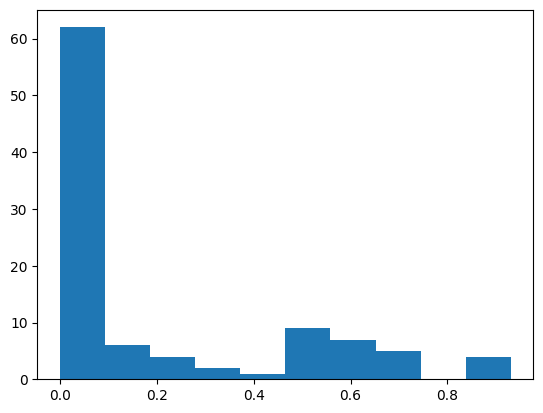

In [17]:

p_vals = np.empty(100)
for i in range(100):
    samples, accepted = metropolis_hastings(target_dist_pdf, proposal_dist.pdf, proposal_dist.rvs, initial_value=5, N=100)
    p_vals[i] = chi2_test(samples[20:], pi)

plt.hist(p_vals)